In [1]:
import sys
sys.path.append('../../ABEL')
from abel import *
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import matplotlib.pyplot as plt

In [3]:
## define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 [m]
driver.num_particles = 100000
driver.jitter.x = 0#2e-7 # [m] 2e-6
driver.jitter.y = 0#2e-7 # [m] 100e-9
driver.jitter.t = 0 #10e-15 # [m]
driver.symmetrize = True
driver.seed = 1

#test_particle = SourceSingleParticle()
#test_particle.energy = 1500e9 # [eV]
#test_particle.z_offset = 0 # [m]
#test_particle.x_offset = 4e-6 # [m]
#test_particle.y_offset = 0 # [m]
#test_particle.y_angle = test_particle.x_offset/pp.beta_matched(2e21, test_particle.energy)
#test_particle.x_angle = 0

# define a stage
stage = StageHipace()
stage.driver_source = driver
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.radiation_reaction = True
stage.ion_motion = False
stage.beam_ionization=False
stage.ramp_beta_mag = 5
stage.num_nodes = 16
#stage.test_particle_source = test_particle

# define witness bunch
witness = SourceBasic()
witness.charge = -1e10 * SI.e # [C]
witness.energy = 1500e9 # [eV]
witness.rel_energy_spread = 0.0
witness.bunch_length = 28e-6 # [m]
witness.z_offset = 0 # [m]
witness.emit_nx, witness.emit_ny = 160e-6, 0.56e-6 # [m rad]
witness.beta_x = stage.matched_beta_function(witness.energy)
witness.beta_y = witness.beta_x
witness.num_particles = 50000
witness.x_offset, witness.y_offset = 0, 0 # [m]
witness.jitter.x = 0
witness.symmetrize = True
witness.seed = driver.seed

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

linac = Linac()
linac.stage = stage
linac.source = witness
linac.num_stages = 1
shots = 1

In [5]:
RR = [False, True]
linac.scan(f'scan_densities_RR_{stage.radiation_reaction}', 
           lambda obj, val: setattr(obj.stage, 'radiation_reaction', val) or obj, 
           RR,
           label='RR_enabled',
           scale=1,
           num_shots_per_step=1, 
           parallel=True,
           overwrite=False);

Output()

>> Finished HiPACE++ (job 6751415): 100%|██████████| 7487/7487 [02:11<00:00, 56.95 steps/s]

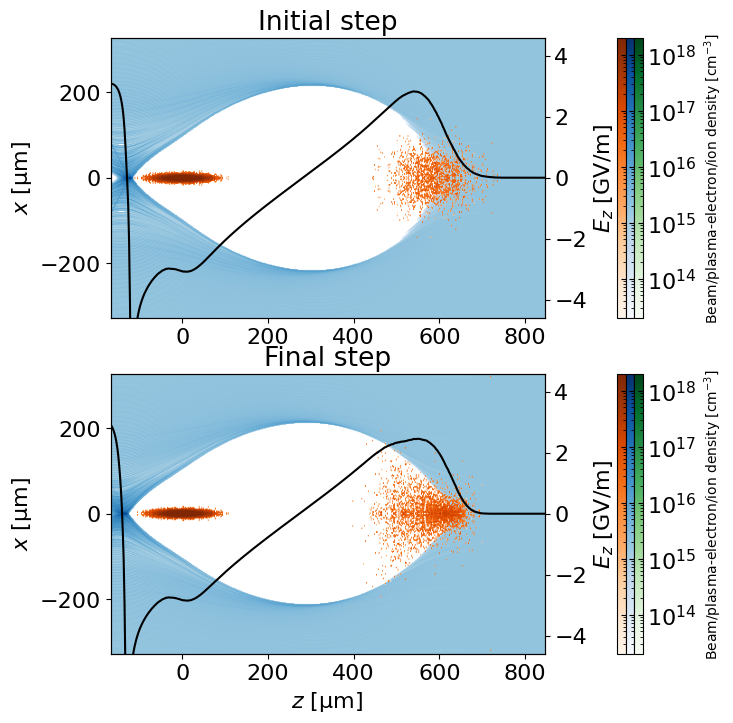

In [6]:
fig = linac.stages[0].plot_wake()

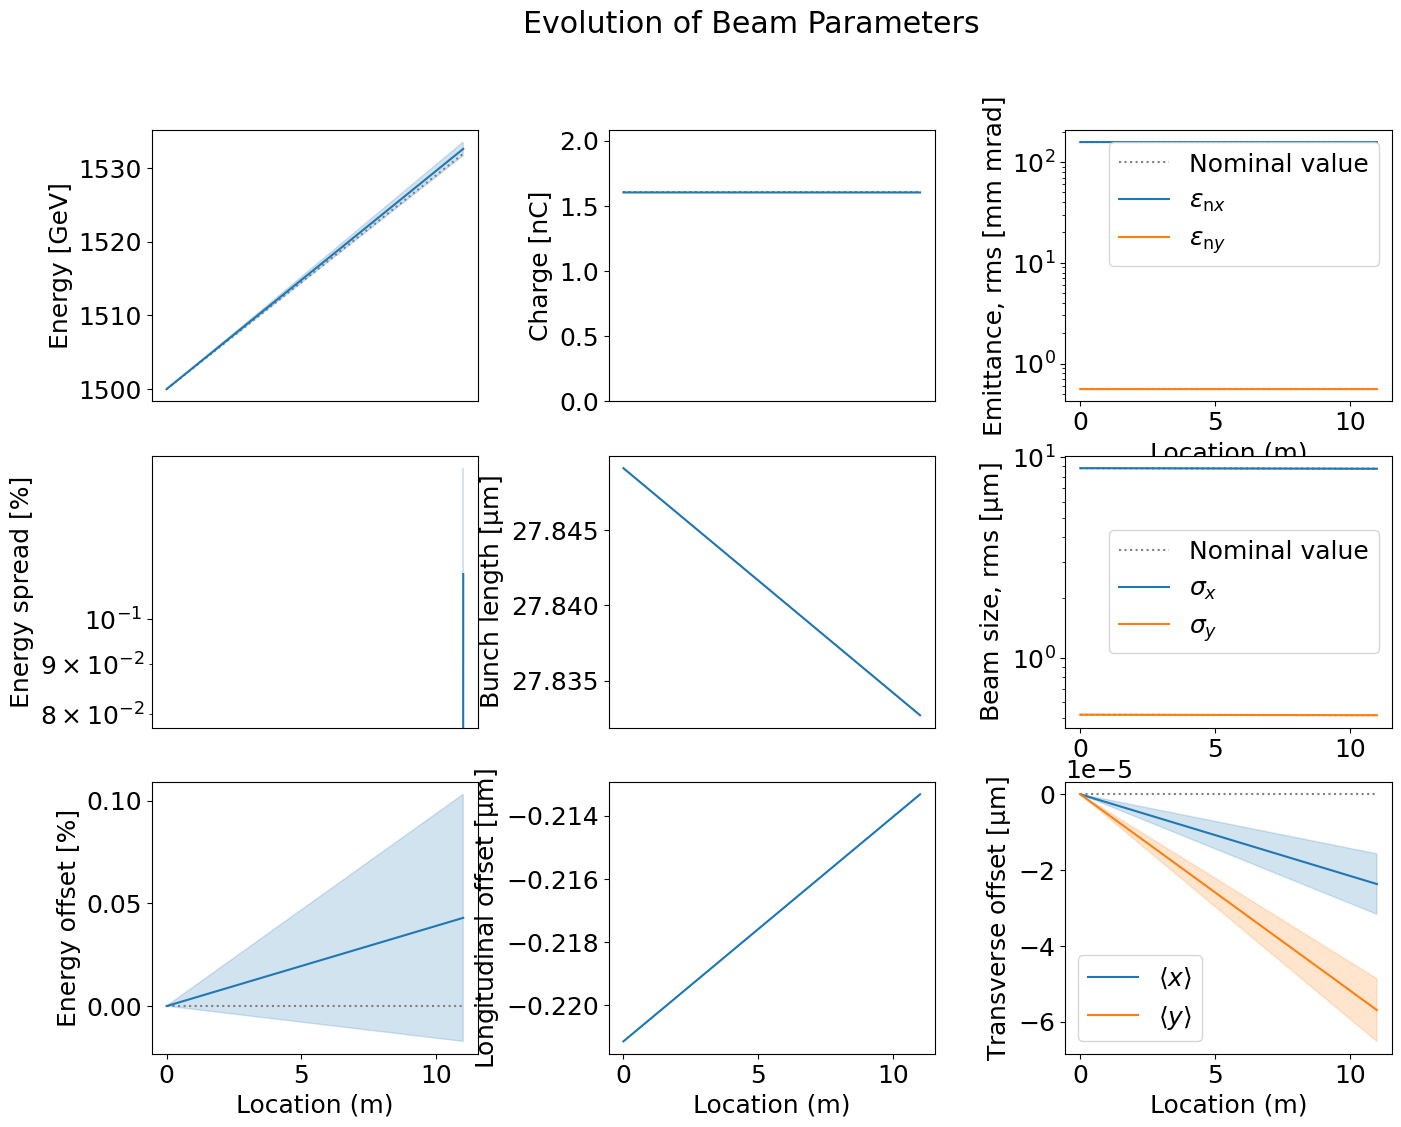

In [8]:
beam_evolution = linac[0].plot_evolution(use_stage_nums=False)

In [12]:
beam_noRR = linac[0].get_beam(-1)
beam_RR = linac[1].get_beam(-1)

In [18]:
E_noRR = beam_noRR.Es()
rel_E_spread_noRR = beam_noRR.rel_energy_spread()
E_RR = beam_RR.Es()
rel_E_spread_RR = beam_RR.rel_energy_spread()
print(E_RR)

[1.52068822e+12 1.52068822e+12 1.52068822e+12 ... 1.55065150e+12
 1.55065150e+12 1.55065150e+12]


In [32]:
print(rel_E_spread_noRR)
print(rel_E_spread_RR)
gamma = np.mean(E_RR*SI.e)/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x_sq = witness.emit_nx/gamma/k_beta
print(np.sqrt(sig_x_sq))
sig_y_sq = witness.emit_ny/gamma/k_beta
expected_spread = SI.e**2*stage.length/6/np.pi/SI.epsilon_0/\
(np.mean(E_RR)*SI.e)*(gamma*k_beta)**4*np.sqrt(sig_x_sq**2+sig_y_sq**2)
print(expected_spread)
print(np.sqrt(rel_E_spread_RR**2-rel_E_spread_noRR**2))

0.0007977484605679332
0.0014254310022035934
3.940856599573773e-06
0.0012062469706323204
0.001181292061983248


In [34]:
print((abs(np.sqrt(rel_E_spread_RR**2-rel_E_spread_noRR**2)-expected_spread))/np.sqrt(rel_E_spread_RR**2-rel_E_spread_noRR**2))

0.021125096368781248


In [36]:
print((0.001206-0.0011813)/0.001181292061983248)

0.020909308370812014
